In [1]:
import collections
import re
from d2l import tensorflow as d2l
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab



ModuleNotFoundError: No module named 'd2l'

In [ ]:
import random
import tensorflow as tf
from d2l import tensorflow as d2l

tokens = tokenize(read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [ ]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield tf.constant(X), tf.constant(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = tf.constant(corpus[offset: offset + num_tokens])
    Ys = tf.constant(corpus[offset + 1: offset + 1 + num_tokens])
    Xs = tf.reshape(Xs, (batch_size, -1))
    Ys = tf.reshape(Ys, (batch_size, -1))
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

train_random_iter, vocab_random_iter = load_data_time_machine(
    batch_size, num_steps, use_random_iter=True)

In [ ]:
tf.one_hot(tf.constant([0, 2]), len(vocab))

<tf.Tensor: shape=(2, 28), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [ ]:
X = tf.reshape(tf.range(10), (2, 5))
tf.one_hot(tf.transpose(X), 28).shape

TensorShape([5, 2, 28])

In [ ]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return tf.random.normal(shape=shape,stddev=0.01,mean=0,dtype=tf.float32)

    # Hidden layer parameters
    W_xh = tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32)
    W_hh = tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32)
    b_h = tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
    # Output layer parameters
    W_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    return params

In [ ]:
def init_rnn_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)), )

In [ ]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        X = tf.reshape(X,[-1,W_xh.shape[0]])
        H = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(H, W_hh) + b_h)
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return tf.concat(outputs, axis=0), (H,)

In [ ]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens,
                 init_state, forward_fn, get_params):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.init_state, self.forward_fn = init_state, forward_fn
        self.trainable_variables = get_params(vocab_size, num_hiddens)

    def __call__(self, X, state):
        X = tf.one_hot(tf.transpose(X), self.vocab_size)
        X = tf.cast(X, tf.float32)
        return self.forward_fn(X, state, self.trainable_variables)

    def begin_state(self, batch_size, *args, **kwargs):
        return self.init_state(batch_size, self.num_hiddens)

In [ ]:
# defining tensorflow training strategy
device_name = d2l.try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)

num_hiddens = 512
with strategy.scope():
    net = RNNModelScratch(len(vocab), num_hiddens, init_rnn_state, rnn,
                          get_params)
state = net.begin_state(X.shape[0])
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

(TensorShape([10, 28]), 1, TensorShape([2, 512]))

In [ ]:
def predict_ch8(prefix, num_preds, net, vocab):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
import numpy as np

In [ ]:
def beam_search(prefix, num_predicts, model, vocab, beam_width=5):
    def get_input(token):
        return np.array([[token]])

    # Initialize state
    state = model.begin_state(batch_size=1)

    # Initial prefix tokens
    outputs = [vocab[prefix[0]]]

    # Warmup state with prefix
    for y in prefix[1:]:
        _, state = model(get_input(outputs[-1]), state)
        outputs.append(vocab[y])

    # Beam search initialization
    beam = [(outputs, 0.0, state)]  # (current tokens, cumulative log probability, current state)

    # Predict num_predicts steps using beam search
    for _ in range(num_predicts):
        new_beam = []

        for tokens, log_prob, state in beam:
            # Get last token
            last_token = tokens[-1]

            if last_token == vocab['<eos>']:
                new_beam.append((tokens, log_prob, state))
                continue

            # Generate next token candidates
            X = get_input(last_token)
            Y, new_state = model(X, state)
            Y = np.array(Y[0])
            # Top beam_width tokens with highest probabilities
            token_indices = Y.argsort()[::-1][:beam_width]

            for token_idx in token_indices:
                new_tokens = tokens + [int(token_idx)]
                new_log_prob = log_prob + np.log(float(Y[token_idx]))
                new_beam.append((new_tokens, new_log_prob, new_state))

        # Sort and select top beam_width candidates
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

    # Select the best candidate
    outputs, log_prob, state = beam[0]

    return ''.join([vocab.idx_to_token[i] for i in outputs if i != vocab['<eos>']])

perplexity 1.1, 8497.8 tokens/sec on /GPU:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


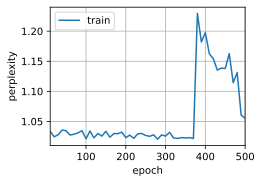

In [ ]:

def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: beam_search(prefix, 50, net, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)

In [ ]:
predict_ch8('time traveller ', 10, net, vocab)

'time traveller <unk>k<unk>zdvfjek'

In [ ]:
def grad_clipping(grads, theta):
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

perplexity 1.0, 8858.5 tokens/sec on /GPU:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


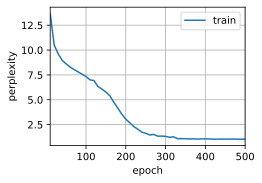

In [ ]:

def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            y_hat, state = net(X, state)
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        params = net.trainable_variables
        grads = g.gradient(l, params)
        grads = grad_clipping(grads, 1)
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * d2l.size(y), d2l.size(y))
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    device = d2l.try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)